# NOVELTY RERANKING (GLOBAL GENRE-BASED DISTANCE)

In [ ]:
from src.experiments.novelty_sweep import run_novelty_sweep

output_csv = "novelty_sweep_genre.csv"
df_nov = run_novelty_sweep(output_csv=output_csv)
df_nov

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../results/sweeps/novelty_sweep_genre.csv")

# sort by novelty_lambda to get smooth curves
df = df.sort_values("novelty_lambda")

# 1) Lambda vs metrics
for metric in ["ndcg", "recall", "novelty", "item_coverage", "item_gini"]:
    plt.figure(figsize=(6,4))
    plt.plot(df["novelty_lambda"], df[metric], marker="o")
    plt.xlabel("novelty_lambda")
    plt.ylabel(metric)
    plt.title(f"{metric} vs novelty_lambda")
    plt.grid(True)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

x = df["novelty"]
y = df["ndcg"]
lam = df["novelty_lambda"]

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label="All configs", alpha=0.6)

# draw Pareto curve
pareto = df.sort_values("novelty")
plt.plot(pareto["novelty"], pareto["ndcg"], "r-o", label="Pareto front")

# annotate each point with λ
for xv, yv, lv in zip(x, y, lam):
    plt.annotate(
        f"{lv:.2f}",
        (xv, yv),
        textcoords="offset points",
        xytext=(3, 3),
        fontsize=8,
    )

plt.xlabel("Novelty (item-to-history distance)")
plt.ylabel("NDCG")
plt.title("Accuracy–novelty tradeoff (genre-based re-ranking)")
plt.legend()
plt.tight_layout()
plt.show()


#### Conclusion
- I fixed the EASE regularization at λ_reg = 100 and reranked its top 100 candidates per user using a global genre-based novelty weight `novelty_lambda`.
- increasing `novelty_lambda` increases novelty metric (from about 0.55 to 0.85) and slightly improves item coverage.
- At the same time, increasing `novelty_lambda` decreases accuracy (NDCG drops from about 0.228 to 0.075).
- The accuracy–novelty Pareto curve is strictly decreasing and smooth, so each value of novelty_lambda corresponds to a different compromise.

# SAVE A NOVELTY-RERANKED SUBMISSION FOR CODABENCH

In [ ]:
from src.data.loader import load_interactions, load_games
from src.models.ease import EASE
from src.novelty.rerank import rerank_with_novelty
from src.pipelines.save import save_submission
import numpy as np
from src.config import LAMBDA_REG

# 1. Load Codabench splits
train = load_interactions(train=True)
test_in = load_interactions(train=False)
games = load_games()

# 2. Load precomputed genre distance
item_distance = np.load("../data/processed/genre_distance.npy")

# 3. Train EASE with fixed lambda_reg
model = EASE(lambda_reg=LAMBDA_REG)

# recommend() already uses a Codabench style mapping
recs_base = model.recommend(train, test_in, top_k=100)

In [ ]:
# 4. Pick a novelty weight, for example, 0.3
NOVELTY_LAMBDA = 1.5

# re-rank scores
recs_novel = rerank_with_novelty(
    recs_base,
    test_in,
    item_distance,
    lambda_val=NOVELTY_LAMBDA,
)

# keep only top-20 per user, sorted by score
recs_novel = (
    recs_novel
    .sort_values(["user_id", "score"], ascending=[True, False])
    .groupby("user_id")
    .head(20)
    .reset_index(drop=True)
)

# drop scores for submission
submission = recs_novel[["user_id", "item_id"]]

# 5. Save for Codabench
save_submission(submission, f"ease_lambda100_nov_{NOVELTY_LAMBDA}")

# NOVELTY RERANKING (USER-SPECIFIC GENRE DISTANCE)

In [1]:
from src.experiments.user_specific_sweep import run_user_specific_sweep

# Profile-size-based weighting
metrics_profile = run_user_specific_sweep(grouping="profile")
metrics_profile

[INFO] Saved: results/sweeps/user_specific_profile.csv


{'ndcg': 0.21924961657696618,
 'recall': 0.3973333333333333,
 'user_coverage': 1.0,
 'item_gini': 0.8159566936208444,
 'publisher_gini': 0.8235627980151584,
 'item_coverage': 0.1314903420166578,
 'intra_list_similarity': 0.30803445,
 'novelty': 0.6591055,
 'grouping': 'profile',
 'ease_lambda_reg': 100}

In [2]:
# Genre-diversity-based weighting
metrics_genre = run_user_specific_sweep(grouping="genre")
metrics_genre

[INFO] Saved: results/sweeps/user_specific_genre.csv


{'ndcg': 0.21488694962847973,
 'recall': 0.38566666666666666,
 'user_coverage': 1.0,
 'item_gini': 0.8157991194968554,
 'publisher_gini': 0.8292867936068891,
 'item_coverage': 0.14088250930356194,
 'intra_list_similarity': 0.29682133,
 'novelty': 0.66553974,
 'grouping': 'genre',
 'ease_lambda_reg': 100}

In [3]:
# Combined strategy
metrics_combined = run_user_specific_sweep(grouping="combined")
metrics_combined

[INFO] Saved: results/sweeps/user_specific_combined.csv


{'ndcg': 0.21752255290732853,
 'recall': 0.3913333333333333,
 'user_coverage': 1.0,
 'item_gini': 0.8170462081128749,
 'publisher_gini': 0.8252125849000072,
 'item_coverage': 0.1339712918660287,
 'intra_list_similarity': 0.2908287,
 'novelty': 0.6662869,
 'grouping': 'combined',
 'ease_lambda_reg': 100}

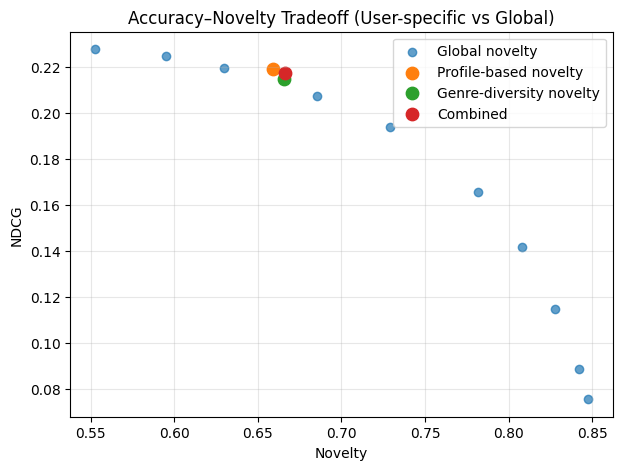

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

global_df = pd.read_csv("../results/sweeps/novelty_sweep_genre.csv")

profile_df = pd.read_csv("../results/sweeps/user_specific_profile.csv")
genre_df   = pd.read_csv("../results/sweeps/user_specific_genre.csv")
combo_df   = pd.read_csv("../results/sweeps/user_specific_combined.csv")

plt.figure(figsize=(7,5))

plt.scatter(global_df["novelty"], global_df["ndcg"], label="Global novelty", alpha=0.7)
plt.scatter(profile_df["novelty"], profile_df["ndcg"], label="Profile-based novelty", s=80)
plt.scatter(genre_df["novelty"], genre_df["ndcg"], label="Genre-diversity novelty", s=80)
plt.scatter(combo_df["novelty"], combo_df["ndcg"], label="Combined", s=80)

plt.xlabel("Novelty")
plt.ylabel("NDCG")
plt.title("Accuracy–Novelty Tradeoff (User-specific vs Global)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### How did we group users?
<b> A) Profile Size Grouping (Interactions per User):</b>
- Users with few interactions have very uncertain distance estimates, too little history to judge novelty → low λ.
- Users with many interactions have a stable, well-defined taste profile → novelty becomes meaningful → higher λ.

- Distribution:
    - mean: 42 items
    - median: 26
    - 25% < 10
    - 50% < 26
    - 75% < 55

| Profile size | Rationale                          | Novelty weight λ |
| ------------ | ---------------------------------- | ---------------- |
| < 10 items   | sparse history, novelty unstable   | **0.05**         |
| 10–55 items  | majority of users, stable baseline | **0.20**         |
| > 55 items   | rich profiles, novelty meaningful  | **0.50**         |

<b> B) Genre Diversity Grouping (Entropy) </b>
- Entropy is a measure of how diverse or spread out the genres in a user's history are.
    - A user who only plays Action has: `entropy ≈ 0`
    - A user who plays Action + RPG + Strategy + Indie has: `entropy ≈ higher`
- Intuition:
    - Low entropy → niche taste → novelty may hurt accuracy
    - High entropy → broad taste → novelty may help
    - Medium entropy → balanced

| Genre Entropy | Meaning         | λ        |
| ------------- | --------------- | -------- |
| low           | niche taste     | **0.05** |
| medium        | mixed           | **0.20** |
| high          | very open taste | **0.50** |

<b> C) Combined Grouping </b>
- You simply take the average λ from profile-size and genre-diversity groups.
- This creates a hybrid behavior:
    - Users with large profiles and high genre entropy → highest novelty
    - Users with small profiles and low entropy → minimal novelty
    - Mixed cases → in between

### Why all user-specific results ended up so close
<b>Reason 1—The majority of users fall in the middle groups</b>

Most users have:
* profile size = 10–55
* entropy = mid-range

→ They all received λ = 0.20.

<b>Reason 2—Low and high groups were small</b>

Very few users received λ = 0.05 or λ = 0.50.

Since only 3000 users were sampled in the sweep, the differences shrink even further.

<b>Reason 3—EASE scores dominate the ranking</b>

EASE provides strong baseline scores, so novelty adjustments with moderate λ values (0.05–0.5) produce only small ranking changes.

<b>`s' = s + λ*N`</b>

### Conclusion: Effect of User-Specific Novelty Weighting
- We tested three user-specific novelty weighting strategies, based on interaction profile size, genre diversity (entropy), and a hybrid of both, and compared them to the global novelty baseline.
- Across all three strategies, the resulting novelty values clustered around 0.66, with NDCG scores between 0.214 and 0.219. These points lie in the same region as the global novelty sweep with λ ≈ 0.1–0.2, which represents the best accuracy–novelty balance for fixed global values.
- <b>The main result is that user-specific novelty weighting does not significantly outperform global novelty weighting.</b>
    - Instead, it reproduces the upper-left portion of the global accuracy–novelty trade-off curve without providing a more favorable trade-off.
- This limited improvement is likely due to:
    - Most users have similar interaction counts, causing many of them to receive the same novelty weight.
    - Genre diversity (entropy) is also being concentrated in a narrow range, again reducing differentiation between users.
    - EASE scores are dominant, so novelty adjustments with moderate λ values (0.05–0.5) produce only small ranking changes.

| Method          | Novelty | NDCG        | Comment                                     |
| --------------- | ------- | ----------- | ------------------------------------------- |
| Profile size    | 0.659   | **0.21925** | Slightly lower novelty, reasonable accuracy |
| Genre diversity | 0.6655  | 0.21489     | Close to profile, a bit worse               |
| Combined        | 0.6663  | 0.21752     | In between                                  |
